In [1]:
import pandas as pd
import regex as re
from collections import Counter
import emoji
from gensim.models.word2vec import Word2Vec
import nltk
#from nltk import word_tokenize--->
from gensim.models import FastText
from gensim.models import KeyedVectors
#from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from gensim.models.callbacks import CallbackAny2Vec
#import matplotlib.pyplot as plt
import keras
#from keras.preprocessing.text import Tokenizer--->
from keras.utils.data_utils import pad_sequences
#from keras.initializers import Constant
from keras.layers import ReLU
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Input, LSTM, Bidirectional, TimeDistributed, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras import Model
from keras.models import load_model
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import math
import torch
#import torch.nn as nn
import tensorflow as tf
#nltk.download('punkt')

2023-05-10 01:55:20.596184: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-10 01:55:20.596231: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df_hing_eng = pd.read_pickle('dataset/hinglish_english_tweet_ids_data.pkl')
#print(df_hing_eng.columns)
#print(df_hing_eng[['tweet_text']])
#df_hing_eng = df_hing_eng['tweet_text']
df_hing_eng = df_hing_eng[['tweet_text']].copy()
print(len(df_hing_eng))
print(df_hing_eng.columns)

422415
Index(['tweet_text'], dtype='object')


In [3]:
#finds the duplicate rows in the unlabeled Hinglish-English data

duplicate_1 = df_hing_eng[df_hing_eng.duplicated(keep='first')]
print(len(duplicate_1))
print(duplicate_1)
#print(type(duplicate_1))

17695
                                               tweet_text
368     Chitti ai hai ai hai chitthi ai hai = I have m...
372     Chitti ai hai ai hai chitthi ai hai = I have m...
393                    Kim Kardashian is virgin. #sarcasm
394                    Kim Kardashian is virgin. #sarcasm
423                    Kim Kardashian is virgin. #sarcasm
...                                                   ...
422093                                                 hi
422100                                   is going to bed.
422121                                             nothin
422141                                           wakes up
422251                                      in the office

[17695 rows x 1 columns]


In [4]:
#removes duplicates

df_hing_eng = df_hing_eng.drop_duplicates(keep='first')
print(len(df_hing_eng))

duplicate_2 = df_hing_eng[df_hing_eng.duplicated(keep='first')]
print(len(duplicate_2))
print(df_hing_eng.columns)

404720
0
Index(['tweet_text'], dtype='object')


In [5]:
df_labeled = pd.read_pickle('dataset/data_soumyadeep.pkl')
df_labeled = df_labeled[['tweet_text', 'is_sarcastic']].copy()
print(len(df_labeled))
print(df_labeled.columns)

94788
Index(['tweet_text', 'is_sarcastic'], dtype='object')


In [6]:
#finds the duplicate rows in the labeled data

duplicate_3 = df_labeled[df_labeled.duplicated(subset=['tweet_text'], keep='first')]
print(len(duplicate_3))
print(duplicate_3)

2895
                                              tweet_text  is_sarcastic
354    RT Apna vyauhar hoga aise jal mein kamal rehat...             0
630    @fittaymunhapka n osky baad amMi ny kha k kuch...             0
686    RT Teen behan ke baad jo aata putra woh trekha...             0
809    Ek aadmi pareshan ho kar Ae bhagwan aisi zinda...             1
844    RT Teen behan ke baad jo aata putra woh trekha...             0
...                                                  ...           ...
94716  RT Teen behan ke baad jo aata putra woh trekha...             0
94721  Roz badh'taa huun jahaa'n se aage // Phir wahi...             0
94747  RT Chhoota vaibhav schooli shiksha shooro ho g...             0
94756                                kya hoga is desh ka             0
94763  @rjauhari lol  unka bhi mast hoga..koi recessi...             0

[2895 rows x 2 columns]


In [7]:
#removes duplicates from labeled data

df_labeled = df_labeled.drop_duplicates(subset=['tweet_text'], keep='first')
print(len(df_labeled))

duplicate_4 = df_labeled[df_labeled.duplicated(keep='first')]
print(len(duplicate_4))
print(df_labeled.columns)

91893
0
Index(['tweet_text', 'is_sarcastic'], dtype='object')


In [8]:
#finds the common rows between unlabeled Hinglish English embedding data and labeled data

common_rows = pd.merge(df_hing_eng, df_labeled, how = 'inner', on=['tweet_text'])
print(common_rows)
len(common_rows)
#print(type(common_rows))

                                              tweet_text  is_sarcastic
0      @ajuonline #sarcasm Haal chaal thik thak hai-s...             1
1               @I_Am_Hollywood - Charlie Haas? #sarcasm             1
2                       Chetan Bhagat #epicmale #sarcasm             1
3      @Bo_jasim86 LOOL 7atheer affaa 3allaik rgoobti...             1
4      @FENUSF tees2al 3anek el 3afiaa 7abeeb galbe ,...             1
...                                                  ...           ...
54025   BHAI NEEND HEE NI ARAHI AKHIR KIA MAZAK HAI??)??             1
54026  - Neend Toh Bachpan Mein Aaya Karti Thi..!! - ...             1
54027  aik larki late night neend se jagi aur.. fb pe...             1
54028  @FarahKhanAli really funny.. lagta hai.... sub...             1
54029  @Rudeicious ab tum meri neend ka aise Mazak ur...             1

[54030 rows x 2 columns]


54030

In [9]:
#removes all the common rows from unlabeled data

#cond = df1['Email'].isin(df2['Email'])
#df1.drop(df1[cond].index, inplace = True)

common = df_hing_eng['tweet_text'].isin(df_labeled['tweet_text'])
df_hing_eng.drop(df_hing_eng[common].index, inplace=True)
print(len(df_hing_eng))
print(df_hing_eng.columns)

common_rows2 = pd.merge(df_hing_eng, df_labeled, how = 'inner', on=['tweet_text'])
#print(common_rows2)
print(len(common_rows2))

350690
Index(['tweet_text'], dtype='object')
0


In [10]:
#removes mentions, '#', emojis, punctuations, special chars, URLs, words containing numbers, spaces from beginning and end of tweets

def data_preprocessing(source):
    
    source = source.str.lower() #lower case chars
    source = source.str.replace("\w*\d\w*","") #removes all words containing numbers
    #source = source.str.replace("#", "")
    #source = source.str.replace("@", "")
    #source = source.str.replace("@[A-Za-z0-9_]+","")
    source = source.str.replace("[@A-Za-z0-9_]*@[@A-Za-z0-9_]*","")
    #source = source.str.replace("#[A-Za-z0-9_]+","")
    source = source.str.replace("[#A-Za-z0-9_]*#[#A-Za-z0-9_]*","")
    source = source.str.replace("\s+|[!$%&()*+, -./:;<=>?\^_`{|}~]\s*"," ")
    source = source.str.replace("http\S+","")
    
    return source

df_hing_eng['tweet_text'] = data_preprocessing(df_hing_eng['tweet_text'])
df_hing_eng['tweet_text'] = df_hing_eng['tweet_text'].apply(lambda s: emoji.replace_emoji(s,""))
df_hing_eng['tweet_text'] = df_hing_eng['tweet_text'].str.strip()
df_hing_eng.head()

/tmp/ipykernel_60092/2924867879.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  source = source.str.replace("\w*\d\w*","") #removes all words containing numbers
/tmp/ipykernel_60092/2924867879.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  source = source.str.replace("[@A-Za-z0-9_]*@[@A-Za-z0-9_]*","")
/tmp/ipykernel_60092/2924867879.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  source = source.str.replace("[#A-Za-z0-9_]*#[#A-Za-z0-9_]*","")
/tmp/ipykernel_60092/2924867879.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  source = source.str.replace("\s+|[!$%&()*+, -./:;<=>?\^_`{|}~]\s*"," ")
/tmp/ipykernel_60092/2924867879.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  source = source.str.replace("http\S+","")


,tweet_text
167,dary emratiba
194,yograj singh dhoni advised dd management to r...
200,seedhe log hai ma beta ab crore ka ghotala ho...
309,ab ham khade ho gaye hain ab ham aur bhi dar...
470,make up hayoona


In [11]:
#removes all the rows with empty lists

df_hing_eng=df_hing_eng[df_hing_eng['tweet_text'].map(lambda d: len(d)) > 0]
df_hing_eng.head(10)

,tweet_text
167,dary emratiba
194,yograj singh dhoni advised dd management to r...
200,seedhe log hai ma beta ab crore ka ghotala ho...
309,ab ham khade ho gaye hain ab ham aur bhi dar...
470,make up hayoona
571,cut marna koi umar se seekhay nahi seekhay in...
804,woh jo kar rahe haen woh desh sewa hae politic...
905,u r aapne chaata nahi ki tarah pehle buta ab m...
1077,bhai tu ek vaio mini laptop le le
1277,aanaayi janichirunengil kashtapettu cash undak...


In [12]:
unlabeled_data = list(df_hing_eng['tweet_text'])
print(unlabeled_data[0:5])

['dary emratiba', 'yograj singh  dhoni advised dd management to release yuvraj   p', 'seedhe log hai ma beta ab  crore ka ghotala ho gaya hoga ab ispe court case karne ki kya jaroorat thi', 'ab ham khade ho gaye hain   ab ham aur bhi daraayenge', 'make up hayoona']


In [13]:
#finds the unique words in the unlabeled data

unique_words = set()
df_hing_eng['tweet_text'].str.lower().str.split().apply(unique_words.update)
unique_words = list(unique_words)
#print(unique_words)
#print('---------------')
print(len(unique_words))

209616


In [14]:
#--->don't run it now
# MULTILINGUAL BERT

from transformers import BertTokenizer, BertModel
#import torch

# Load pre-trained model tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased')

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
#--->don't run it now
# Define batch size
batch_size = 32

# Tokenize and encode input data in batches
encoded_inputs = []
for i in range(0, len(unlabeled_data), batch_size):
    inputs = unlabeled_data[i:i+batch_size]
    encoded_inputs.append(tokenizer.batch_encode_plus(inputs, padding=True, truncation=True, return_tensors="pt"))

# Generate embeddings for each batch
embeddings = []
for encoded_input in tqdm(encoded_inputs):
    with torch.no_grad():
        model_output = model(**encoded_input)
    batch_embeddings = model_output.last_hidden_state.mean(dim=1)
    embeddings.append(batch_embeddings)

#print(embeddings)
#print("--------------------")
# Concatenate the embeddings from all batches into a single tensor
embeddings = torch.cat(embeddings, dim=0)
#print(embeddings)

# Save the embeddings tensor
torch.save(embeddings, 'multi_bert_embeddings_hing_eng.npy')

# Load the embeddings tensor
#embeddings = torch.load('multi_bert_embeddings_hing_eng.npy')


100%|██████████████████████████████████| 10956/10956 [14:08:32<00:00,  4.65s/it]


In [16]:
# Load the embeddings tensor
embeddings = np.load('multi_bert_embeddings_hing_eng.npy')
print(embeddings)

In [17]:
embeddings = tf.concat(embeddings, axis=0) 
#print(embeddings_new)
#embeddings_new = embeddings_new.cpu().detach().numpy()
embedding_matrix = model.embeddings.word_embeddings.weight
embedding_matrix = embedding_matrix.cpu().detach().numpy()
print(embedding_matrix.shape)
print(embedding_matrix.shape[0])
print(type(embedding_matrix))
print(embedding_matrix)
embed_tensor = tf.convert_to_tensor(embedding_matrix, dtype=tf.float32)
print(embed_tensor)
print(embed_tensor.shape)

2023-05-10 16:21:52.840190: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-10 16:21:52.869362: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-10 16:21:52.961047: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (user-PC): /proc/driver/nvidia/version does not exist
2023-05-10 16:21:54.771441: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(119547, 768)
119547
<class 'numpy.ndarray'>
[[ 0.02595074 -0.00617341 -0.00409975 ...  0.02965234  0.02417551
   0.01970279]
 [ 0.01038065 -0.0136286   0.00672081 ...  0.01237162  0.0267217
   0.03370738]
 [ 0.0220679  -0.00360613  0.01932366 ...  0.0069061   0.026809
   0.00498276]
 ...
 [ 0.00684139  0.01885802  0.02666426 ...  0.02292391  0.06465269
   0.04373793]
 [ 0.0183579   0.01480132  0.02434449 ...  0.03205629  0.00708906
   0.02039703]
 [ 0.02139908  0.01879423 -0.01343376 ... -0.00597953  0.00583893
  -0.00586251]]
tf.Tensor(
[[ 0.02595074 -0.00617341 -0.00409975 ...  0.02965234  0.02417551
   0.01970279]
 [ 0.01038065 -0.0136286   0.00672081 ...  0.01237162  0.0267217
   0.03370738]
 [ 0.0220679  -0.00360613  0.01932366 ...  0.0069061   0.026809
   0.00498276]
 ...
 [ 0.00684139  0.01885802  0.02666426 ...  0.02292391  0.06465269
   0.04373793]
 [ 0.0183579   0.01480132  0.02434449 ...  0.03205629  0.00708906
   0.02039703]
 [ 0.02139908  0.01879423 -0.01343376 ... -0.005

In [18]:
#PCA

# Scale data before applying PCA
scaling=StandardScaler()
 
# Use fit and transform method
scaling.fit(embed_tensor)
scaled_tensor=scaling.transform(embed_tensor)
 
# Set the n_components=300
principal=PCA(n_components=300)
principal.fit(scaled_tensor)
pca_tensor=principal.transform(scaled_tensor)
 
# Check the dimensions of data after PCA
print(pca_tensor.shape)
print(type(pca_tensor))
print(pca_tensor)

(119547, 300)
<class 'numpy.ndarray'>
[[-4.91974814 -1.61339179 -0.63827766 ...  0.0508665   0.25890825
  -0.2667432 ]
 [-4.89830028 -1.6432148  -0.70061465 ...  0.35355144 -0.04834529
   0.14917765]
 [-4.60616484 -1.67285847 -0.75213217 ...  0.10452468 -0.152253
   0.12035251]
 ...
 [-4.10969564 -2.58837585 -1.46543568 ...  0.14412639 -0.26956225
   0.22987172]
 [-4.24502679 -1.54853605 -1.03434299 ... -0.10323729 -0.14300529
  -0.58130644]
 [-4.06131619 -1.74704907 -1.1756017  ...  0.17205793 -0.82227221
  -0.14034306]]


In [19]:
print(df_labeled.head())
print(len(df_labeled))

                                          tweet_text  is_sarcastic
0  LOL !  BC badaa gaandu hai to ! so jaa lodu ! ...             1
1  @OFFICIAL_FC_PAK apni sakh khud sambhalen aur ...             0
2  Ek aadmi pareshan ho kar Ae bhagwan aisi zinda...             1
3  Lol RT @ThePrachi: @shrikhande Who can sing a ...             1
4  @idrinkblueblood tu ol's kar rahi ho kya? Kya ...             0
91893


In [20]:
#removes mentions, '#', emojis, punctuations, special chars, URLs, words containing numbers, spaces from beginning and end of tweets

def data_preprocessing(source):
    
    source = source.str.lower() #lower case chars
    source = source.str.replace("\w*\d\w*","") #removes all words containing numbers
    #source = source.str.replace("#", "")
    #source = source.str.replace("@", "")
    #source = source.str.replace("@[A-Za-z0-9_]+","")
    source = source.str.replace("[@A-Za-z0-9_]*@[@A-Za-z0-9_]*","")
    #source = source.str.replace("#[A-Za-z0-9_]+","")
    source = source.str.replace("[#A-Za-z0-9_]*#[#A-Za-z0-9_]*","")
    source = source.str.replace("\s+|[!$%&()*+, -./:;<=>?\^_`{|}~]\s*"," ")
    source = source.str.replace("http\S+","")
    
    return source

df_labeled['tweet_text'] = data_preprocessing(df_labeled['tweet_text'])
df_labeled['tweet_text'] = df_labeled['tweet_text'].apply(lambda s: emoji.replace_emoji(s,""))
df_labeled['tweet_text'] = df_labeled['tweet_text'].str.strip()
df_labeled[['tweet_text']].head()

/tmp/ipykernel_60092/3018622983.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  source = source.str.replace("\w*\d\w*","") #removes all words containing numbers
/tmp/ipykernel_60092/3018622983.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  source = source.str.replace("[@A-Za-z0-9_]*@[@A-Za-z0-9_]*","")
/tmp/ipykernel_60092/3018622983.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  source = source.str.replace("[#A-Za-z0-9_]*#[#A-Za-z0-9_]*","")
/tmp/ipykernel_60092/3018622983.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  source = source.str.replace("\s+|[!$%&()*+, -./:;<=>?\^_`{|}~]\s*"," ")
/tmp/ipykernel_60092/3018622983.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  source = source.str.replace("http\S+","")


,tweet_text
0,lol bc badaa gaandu hai to so jaa lodu tere...
1,apni sakh khud sambhalen aur kisi ka saath na ...
2,ek aadmi pareshan ho kar ae bhagwan aisi zinda...
3,lol rt who can sing a group song alone raavan...
4,tu ol s kar rahi ho kya kya hoga tere kaam sir...


In [21]:
df_labeled.head()

,tweet_text,is_sarcastic
0,lol bc badaa gaandu hai to so jaa lodu tere...,1
1,apni sakh khud sambhalen aur kisi ka saath na ...,0
2,ek aadmi pareshan ho kar ae bhagwan aisi zinda...,1
3,lol rt who can sing a group song alone raavan...,1
4,tu ol s kar rahi ho kya kya hoga tere kaam sir...,0


In [23]:
#finds the unique words in the labeled data

unique_words = set()
df_labeled['tweet_text'].str.lower().str.split().apply(unique_words.update)
unique_words = list(unique_words)
#print(unique_words)
#print('---------------')
print(len(unique_words))

93958


In [24]:
labeled_data = list(df_labeled['tweet_text'])
print(labeled_data[0:5])


['lol  bc badaa gaandu hai to  so jaa lodu  tere se kuch nahi hoga', 'apni sakh khud sambhalen aur kisi ka saath na dein yehi log baad mein badnam karte hein inko lage rhne dein', 'ek aadmi pareshan ho kar ae bhagwan aisi zindagi se to maut achi tabhi yamdut aa gaya bola chalo aadmi bhagwan ab kya insaan mazak b na k', 'lol rt  who can sing a group song alone raavan har baar rajnikanth thodi hota hai yaar', 'tu ol s kar rahi ho kya kya hoga tere kaam sirf music aur tv dekhna    p']


In [25]:
def tokenize_labeled_data(data):
    tokenized_sentences = []
    for sentence in data:
        # Apply the tokenizer to each sentence to obtain its tokens
        tokens = tokenizer.encode(sentence, add_special_tokens=True, return_tensors ="tf", padding='max_length', truncation='only_first')
        # Append the tokenized sentence to the list
        tokenized_sentences.append(tokens)

    token_tensor = tf.convert_to_tensor(tokenized_sentences, dtype=tf.float32)
    #token_tensor = tf.convert_to_tensor(tokenized_sentences)
    #print(token_tensor)
    #print(len(token_tensor))
    #print(type(token_tensor))
    #print('----------------------------')
    token_tensor = token_tensor[:, 0, :]
    #print(token_tensor)
    #print(len(token_tensor))
    #print(type(token_tensor))
    return token_tensor

x_train,x_test,y_train,y_test=train_test_split(labeled_data, df_labeled['is_sarcastic'], test_size=0.30, random_state=42)
training_tensor = tokenize_labeled_data(x_train)
test_tensor = tokenize_labeled_data(x_test)

print(training_tensor)
print('----------------------------')
print(test_tensor)

2023-05-10 16:42:19.837555: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 131737600 exceeds 10% of free system memory.


tf.Tensor(
[[  101. 57087. 17714. ...     0.     0.     0.]
 [  101. 63923. 13998. ...     0.     0.     0.]
 [  101. 21695. 10161. ...     0.     0.     0.]
 ...
 [  101. 10148. 10457. ...     0.     0.     0.]
 [  101. 16334. 13158. ...     0.     0.     0.]
 [  101. 19540. 12541. ...     0.     0.     0.]], shape=(64325, 512), dtype=float32)
----------------------------
tf.Tensor(
[[  101. 10398. 10340. ...     0.     0.     0.]
 [  101.   178. 14383. ...     0.     0.     0.]
 [  101. 11499. 48502. ...     0.     0.     0.]
 ...
 [  101. 52661. 10107. ...     0.     0.     0.]
 [  101. 10192. 12923. ...     0.     0.     0.]
 [  101. 28335. 10410. ...     0.     0.     0.]], shape=(27568, 512), dtype=float32)


In [26]:
length = []
#for row in x_train:
for row in training_tensor:
    #print(row)
    #print(len(row))
    #count = count+1
    #if len(row)>maxi:
    #print(len(row))
    length.append(len(row))
        
#print(length)
print("Max length--->", max(length))
print("Mean length--->", np.mean(length))
print("Standard Deviation of length--->", np.std(length))

#maxi = max(length)
maxi = np.round(np.mean(length) + np.std(length)).astype(int)
print("Maximum length of the sequence--->", maxi)

Max length---> 512
Mean length---> 512.0
Standard Deviation of length---> 0.0
Maximum length of the sequence---> 512


In [27]:
#labels = list(df_labeled['is_sarcastic'])
#print(labels)
#print('------------------------')
#print(labeled_data)
#print(type(labels))
#labels = np.array(labels).astype('float32') 
#labels = tf.cast(labels, dtype=tf.float32)
y_train_lst = list(y_train)
y_test_lst = list(y_test)
training_labels = tf.convert_to_tensor(y_train_lst, dtype=tf.float32)
test_labels = tf.convert_to_tensor(y_test_lst, dtype=tf.float32)
print(training_labels)
print(type(training_labels))
print('------------------------')
print(test_labels)
print(type(test_labels))

tf.Tensor([0. 1. 1. ... 0. 0. 1.], shape=(64325,), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>
------------------------
tf.Tensor([0. 1. 1. ... 0. 0. 0.], shape=(27568,), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [28]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

In [29]:
#Attention BiLSTM

from keras import backend as K
#from keras.engine.topology import Layer
from keras.layers import Layer
from keras import initializers, regularizers, constraints


class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight( shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        #print(self.name)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [30]:
lstm_out1 = 150
embed_dim = 300

inp = Input(shape=(maxi, ))
x = Embedding(pca_tensor.shape[0], embed_dim, weights=[pca_tensor], trainable=False)(inp)
x = Bidirectional(LSTM(lstm_out1, return_sequences=True, dropout=0.20, recurrent_dropout=0.20))(x)
x = Attention(maxi)(x)
x = Dense(64, activation="relu")(x)
#x = Dropout(0.25)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
model.summary()

2023-05-10 16:44:34.678425: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 143456400 exceeds 10% of free system memory.
2023-05-10 16:44:48.706487: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 143456400 exceeds 10% of free system memory.
2023-05-10 16:44:48.871879: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 143456400 exceeds 10% of free system memory.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 embedding (Embedding)       (None, 512, 300)          35864100  
                                                                 
 bidirectional (Bidirectiona  (None, 512, 300)         541200    
 l)                                                              
                                                                 
 attention (Attention)       (None, 300)               812       
                                                                 
 dense (Dense)               (None, 64)                19264     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                             

/home/user/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [31]:
hist = model.fit(training_tensor, training_labels, batch_size=64, epochs=20, validation_split=0.1, shuffle=True, callbacks = callbacks_list)

Epoch 1/20


2023-05-10 16:46:01.155039: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 143456400 exceeds 10% of free system memory.


905/905 [==============================] - 9461s 10s/step - loss: 0.2038 - accuracy: 0.9242 - val_loss: 0.1252 - val_accuracy: 0.9663
Epoch 2/20
905/905 [==============================] - 6459s 7s/step - loss: 0.1113 - accuracy: 0.9692 - val_loss: 0.1168 - val_accuracy: 0.9702
Epoch 3/20
905/905 [==============================] - 5708s 6s/step - loss: 0.1014 - accuracy: 0.9711 - val_loss: 0.1113 - val_accuracy: 0.9683
Epoch 4/20
905/905 [==============================] - 7559s 8s/step - loss: 0.0922 - accuracy: 0.9722 - val_loss: 0.1129 - val_accuracy: 0.9678
Epoch 5/20
905/905 [==============================] - 6204s 7s/step - loss: 0.0844 - accuracy: 0.9742 - val_loss: 0.1136 - val_accuracy: 0.9675
Epoch 6/20
905/905 [==============================] - 5656s 6s/step - loss: 0.0762 - accuracy: 0.9756 - val_loss: 0.1163 - val_accuracy: 0.9646
Epoch 7/20
905/905 [==============================] - 4910s 5s/step - loss: 0.0669 - accuracy: 0.9781 - val_loss: 0.1173 - val_accuracy: 0.9613
Ep

In [32]:
model.save('att_bilstm.h5') 

/home/user/anaconda3/lib/python3.9/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


NotImplementedError: 
Layer Attention has arguments ['self', 'step_dim', 'W_regularizer', 'b_regularizer', 'W_constraint', 'b_constraint', 'bias']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config

In [33]:
#model = load_model('att_bilstm.h5')
y_pred_proba = model.predict(test_tensor)
#print(y_pred_proba)
#print('---------------')

y_pred_class = np.round(y_pred_proba)
y_pred_class = y_pred_class.squeeze() #makes y_pred_class 1 dim
'''print(y_pred_class)
print(type(y_pred_class))
print(len(y_pred_class))
print(len(y_test))
print('---------------')'''

acc = accuracy_score(test_labels, y_pred_class) * 100
print("Accuracy is--->", acc)

862/862 [==============================] - 976s 1s/step
Accuracy is---> 96.70269878119558


In [34]:
print(classification_report(test_labels, y_pred_class))

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     13944
         1.0       0.98      0.96      0.97     13624

    accuracy                           0.97     27568
   macro avg       0.97      0.97      0.97     27568
weighted avg       0.97      0.97      0.97     27568



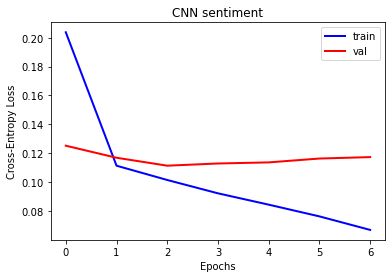

In [35]:
#generate plots
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

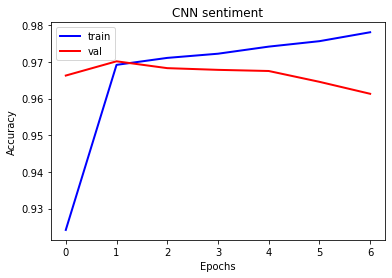

In [36]:
plt.figure()
plt.plot(hist.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

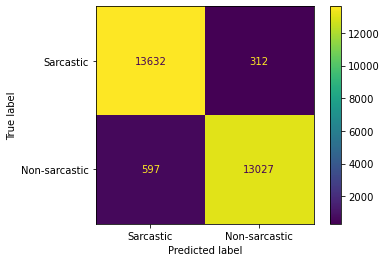

In [37]:
#generates the confusion matrix

labels = ['Sarcastic', 'Non-sarcastic']
cm = confusion_matrix(test_labels, y_pred_class)
ConfusionMatrixDisplay(cm, display_labels=labels).plot()

In [42]:
#saves the BERT model 

torch.save(model, './bert_model.pth')

INFO:tensorflow:Assets written to: ram://706176a4-9cbe-4fd6-84e9-97ba1d8cc918/assets


/home/user/anaconda3/lib/python3.9/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/user/anaconda3/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [46]:
#saves the BERT tokenizer

tokenizer.save_pretrained('./')

('./tokenizer_config.json',
 './special_tokens_map.json',
 './vocab.txt',
 './added_tokens.json')